In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
-----
## $f_3(x_1, x_2, x_3, x_4, )$

##### $f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$

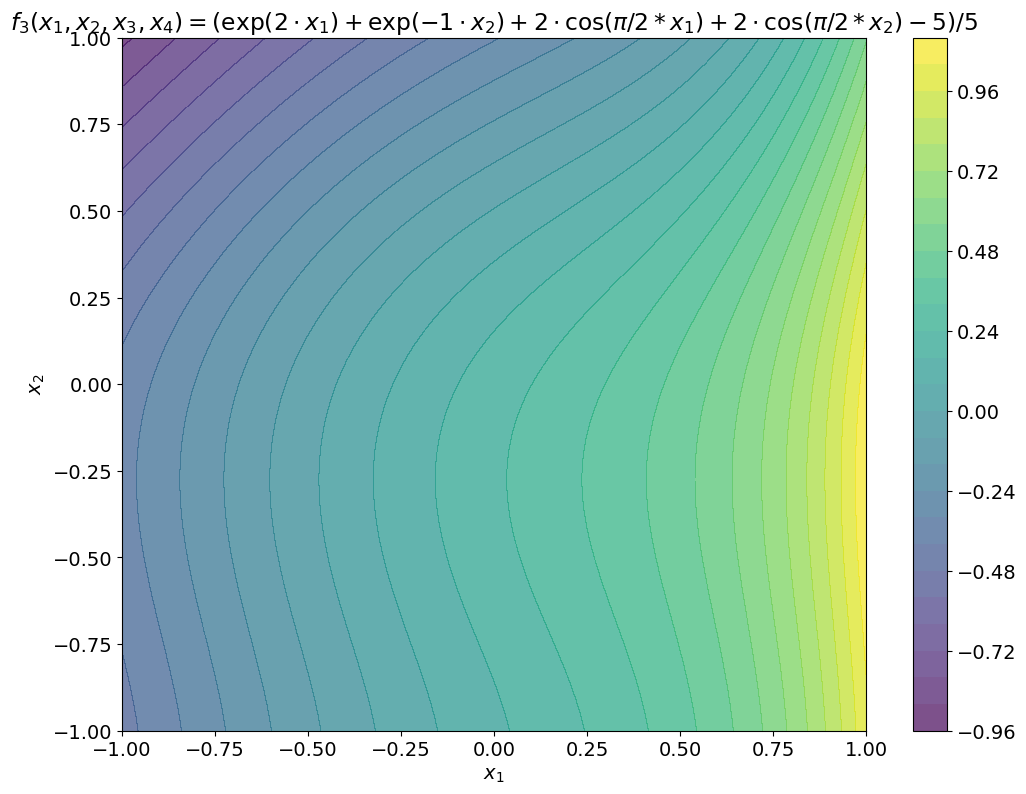

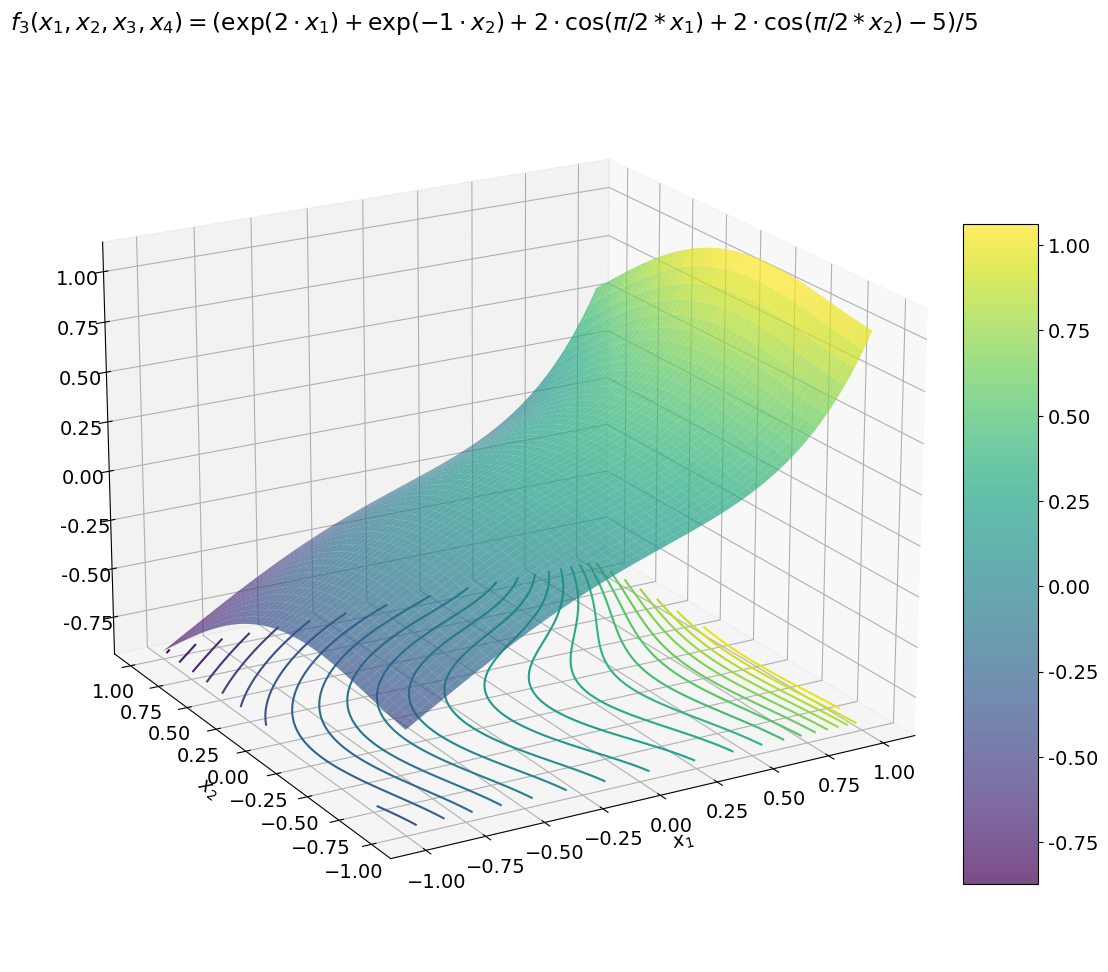

In [5]:
# create dataset
a1, a2, b1, b2 = 2, -1, 2, 2
f3 = lambda x: (torch.exp(a1*x[:,[0]]) + torch.exp(a2*x[:,[1]]) + b1*torch.cos(torch.pi/2*x[:,[0]]) + b2*torch.cos(torch.pi/2*x[:,[1]]) -5 ) / 5
dataset3 = create_dataset(f3, n_var=4, device=device)

f = f3
dataset = dataset3

plot_f_2d(f3, title=f'$f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$')
plot_f_3d(f3, title=f'$f_3(x_1, x_2, x_3, x_4) = (\exp({a1} \cdot x_1) + \exp({a2} \cdot x_2) + {b1} \cdot \cos(\pi / 2 * x_1) + {b2} \cdot \cos(\pi / 2 * x_2) - 5) / 5$')

-----
### MLP on $f_3$

№ model trainable params: 246


| train_loss: 2.56e-03 | test_loss: 2.48e-03 | reg: 6.65e+01 | : 100%|█| 100/100 [00:07<00:00, 12.73


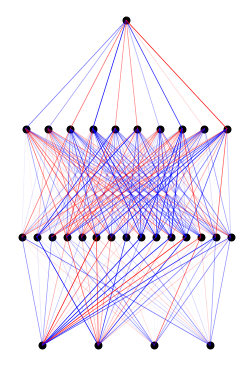

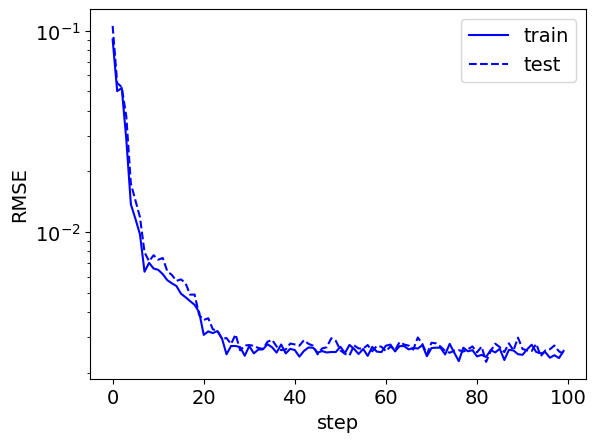

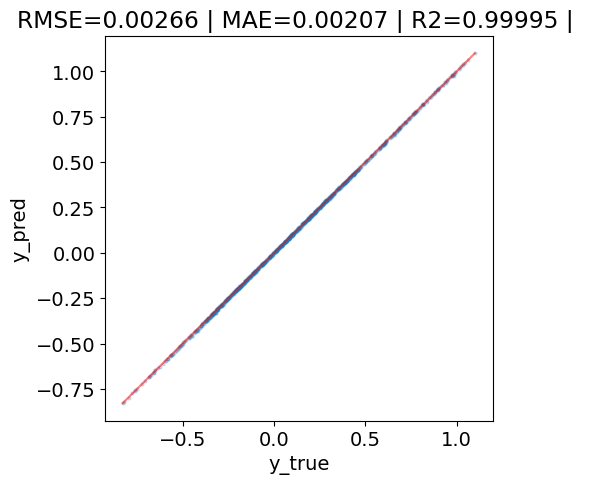

In [8]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_3$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 1.76e-03 | test_loss: 1.87e-03 | reg: 5.80e+00 | : 100%|█| 100/100 [00:50<00:00,  1.97


saving model version 0.1


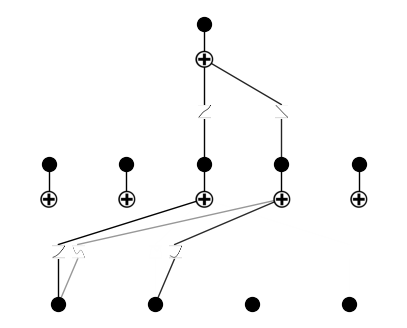

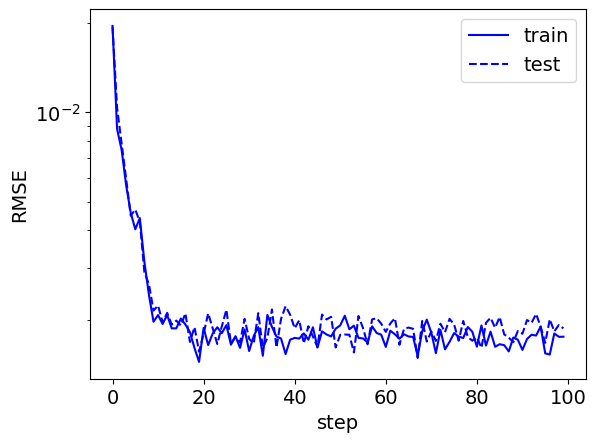

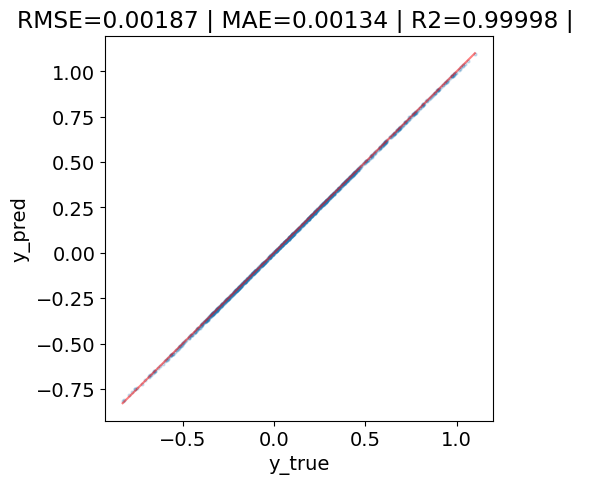

In [10]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN on $f_3$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.40e-02 | test_loss: 3.66e-02 | reg: 1.19e+01 | : 100%|█| 150/150 [00:57<00:00,  2.62


saving model version 0.1


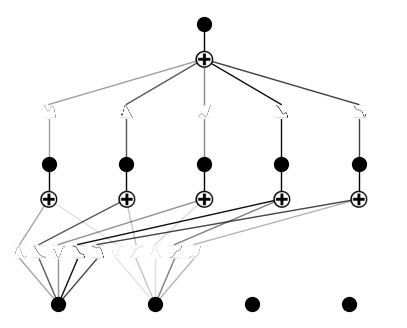

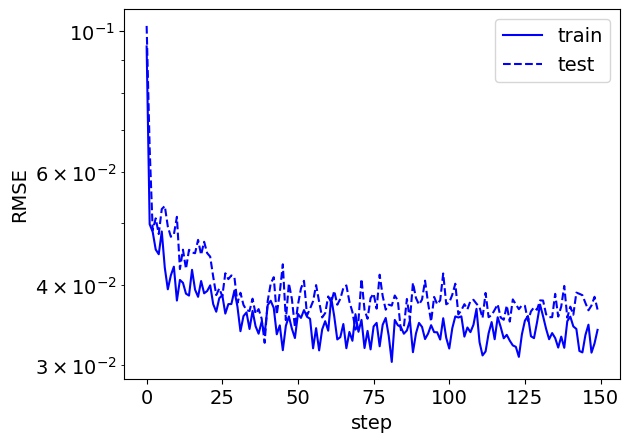

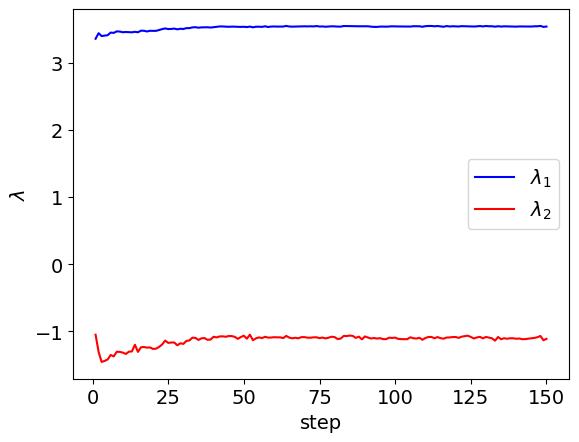

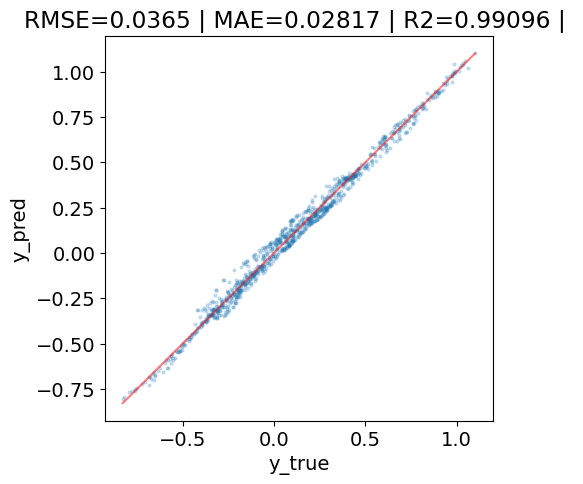

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.5431e+00, -1.1128e+00, -6.4514e-03, -9.0192e-04],
       requires_grad=True)


In [11]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:38, 22.08it/s]                          


module of Input importance:


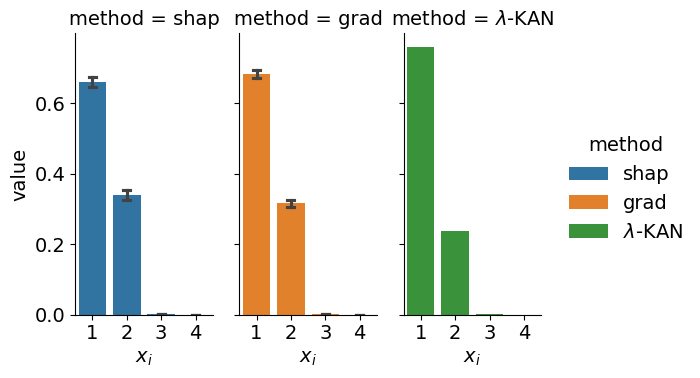

Input importance:


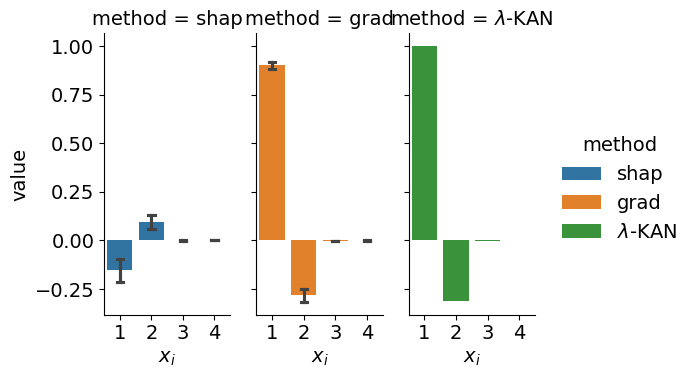

In [12]:
importance_analyse_lmdKAN(model, dataset)

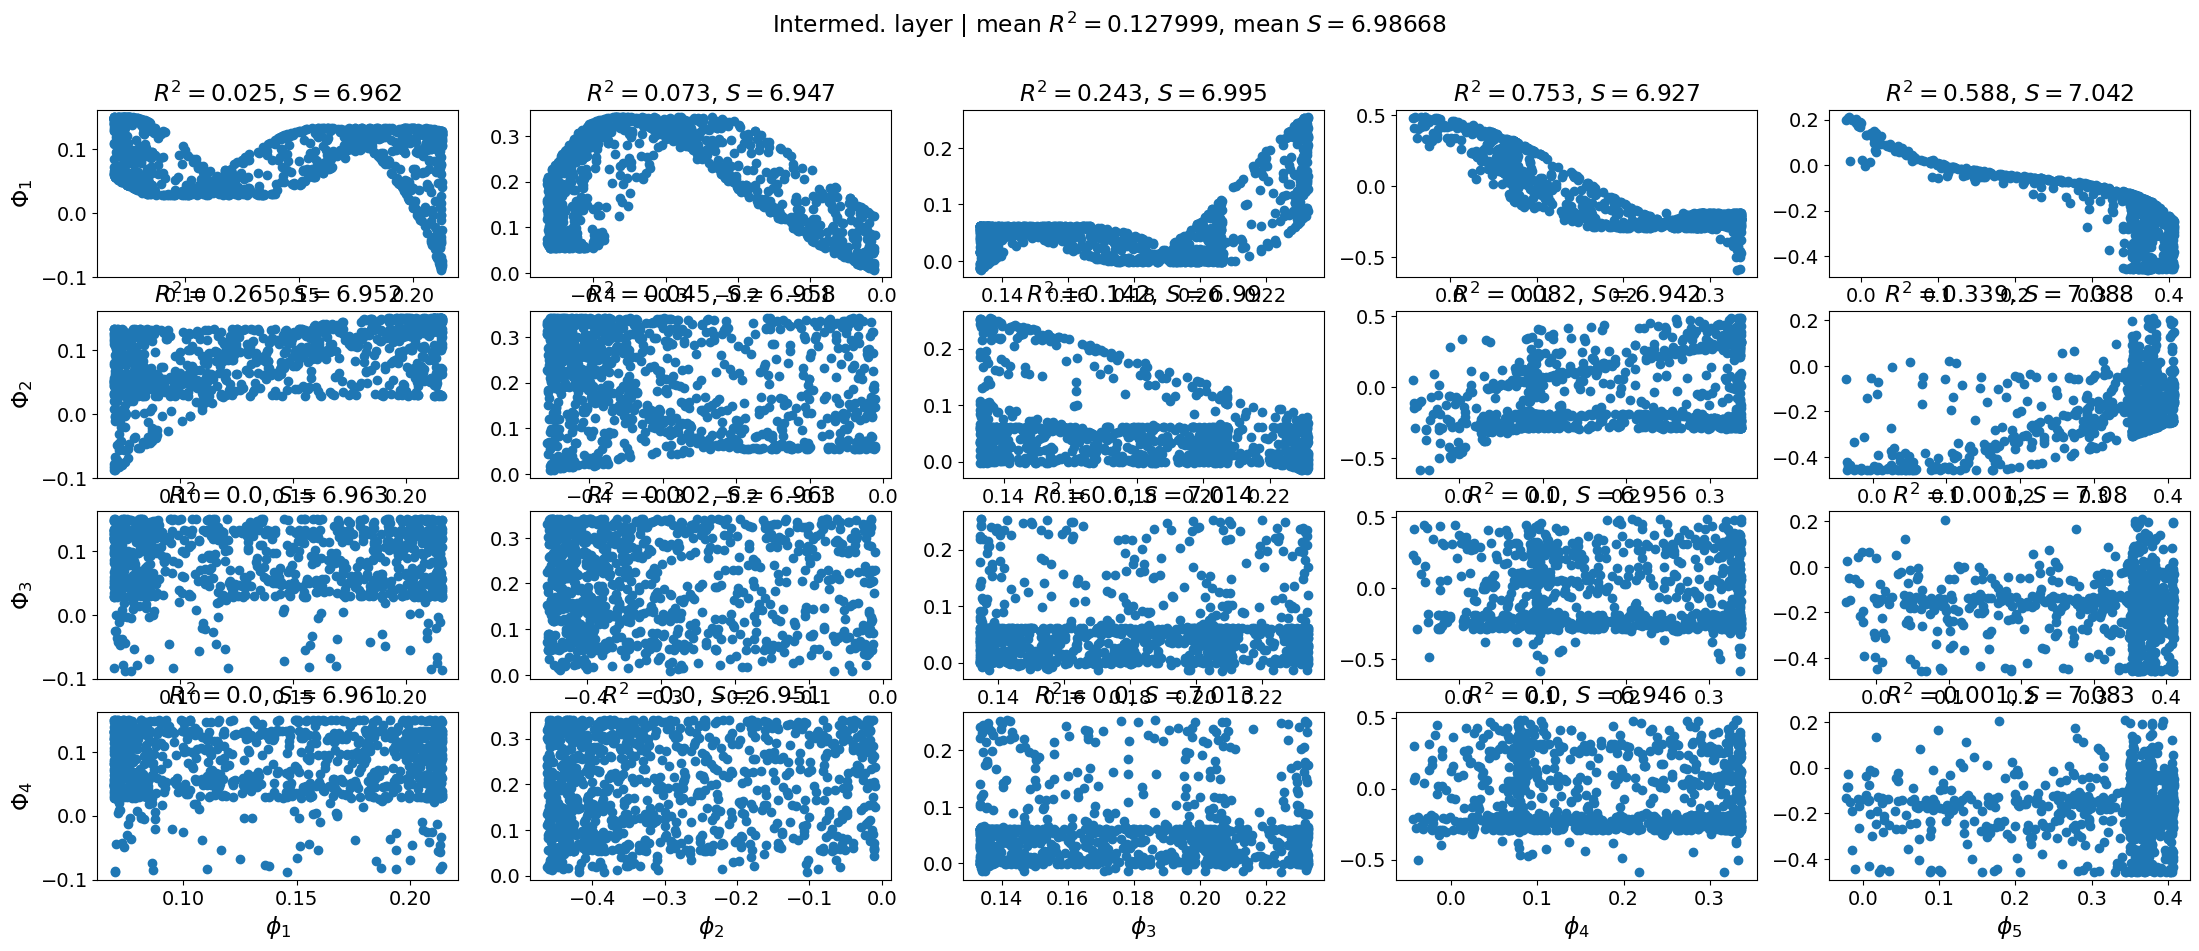

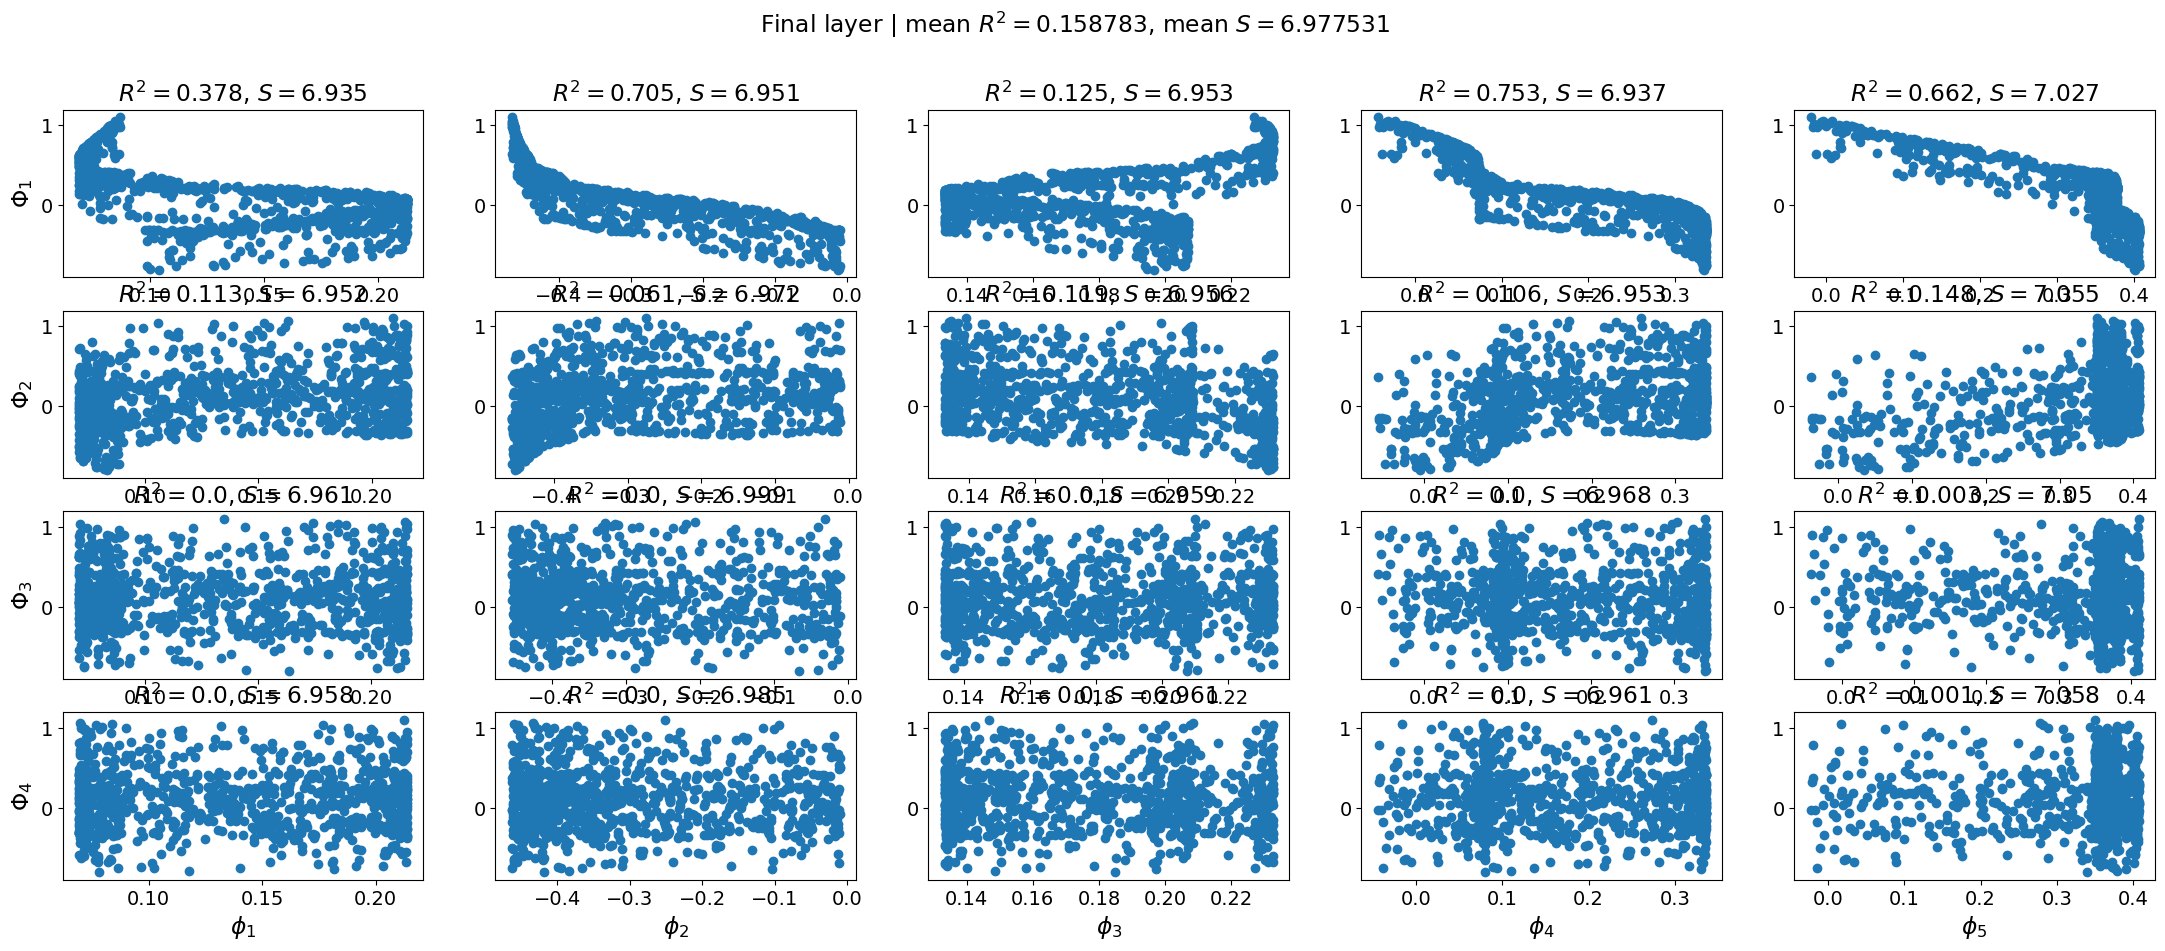

{'mean_r2': 0.1587829112459076, 'mean_matrix_entropy': 6.977531433105469}

In [13]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_3$ with __R2 regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.42e-02 | test_loss: 3.70e-02 | reg: 6.78e+00 | : 100%|█| 150/150 [02:54<00:00,  1.16


saving model version 0.1


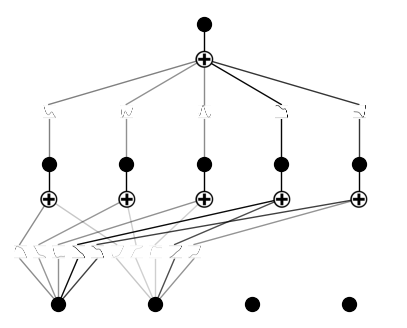

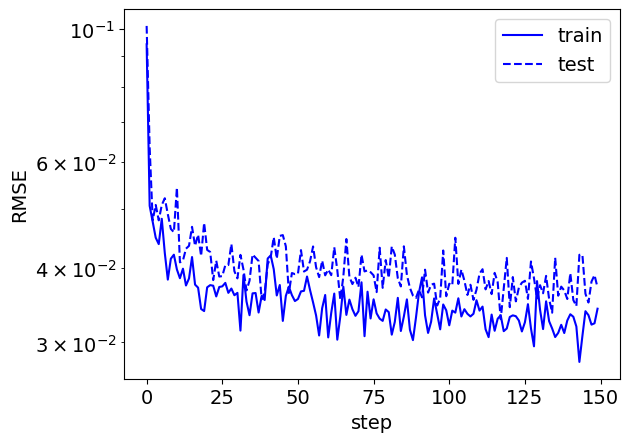

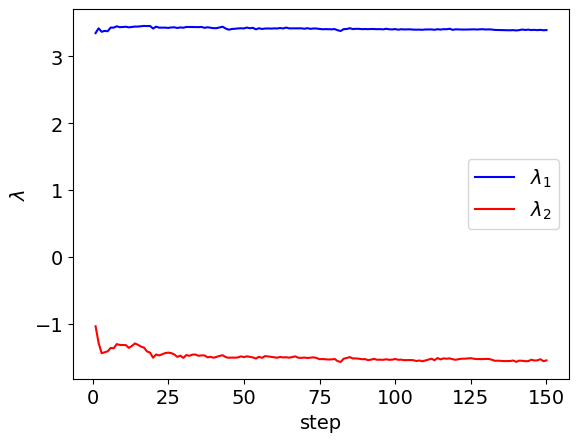

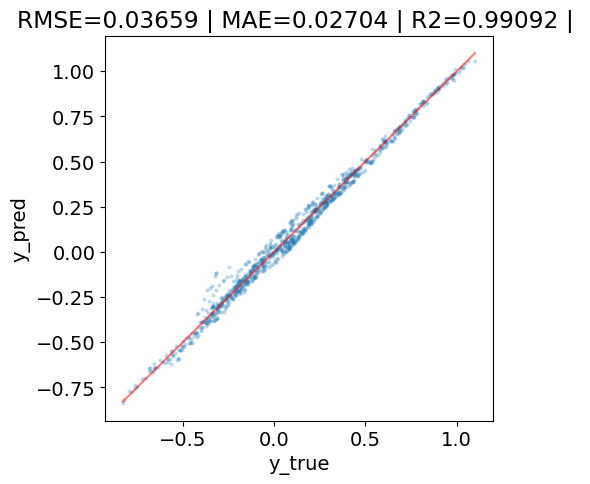

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.3930e+00, -1.5475e+00, -1.8875e-04,  1.1422e-04],
       requires_grad=True)


In [14]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:37, 21.03it/s]                         


module of Input importance:


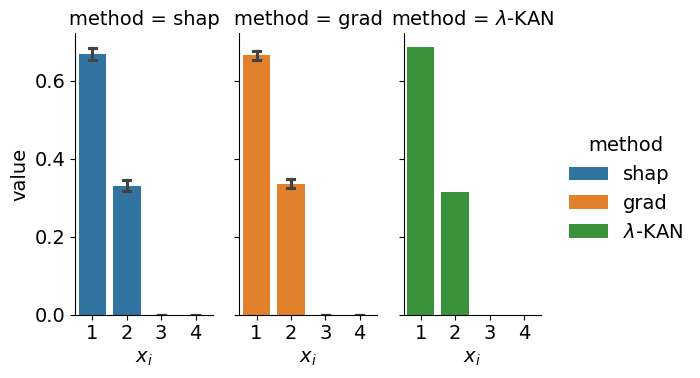

Input importance:


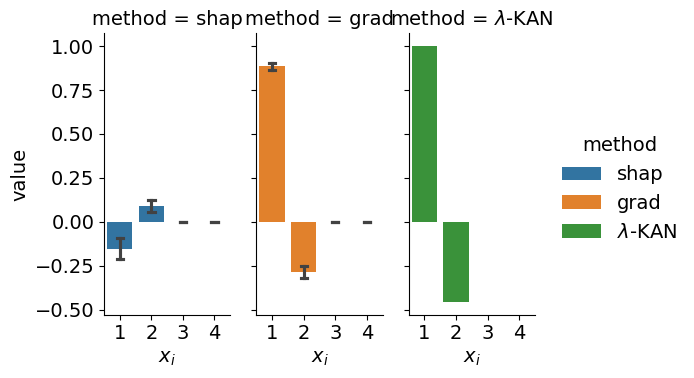

In [15]:
importance_analyse_lmdKAN(model, dataset)

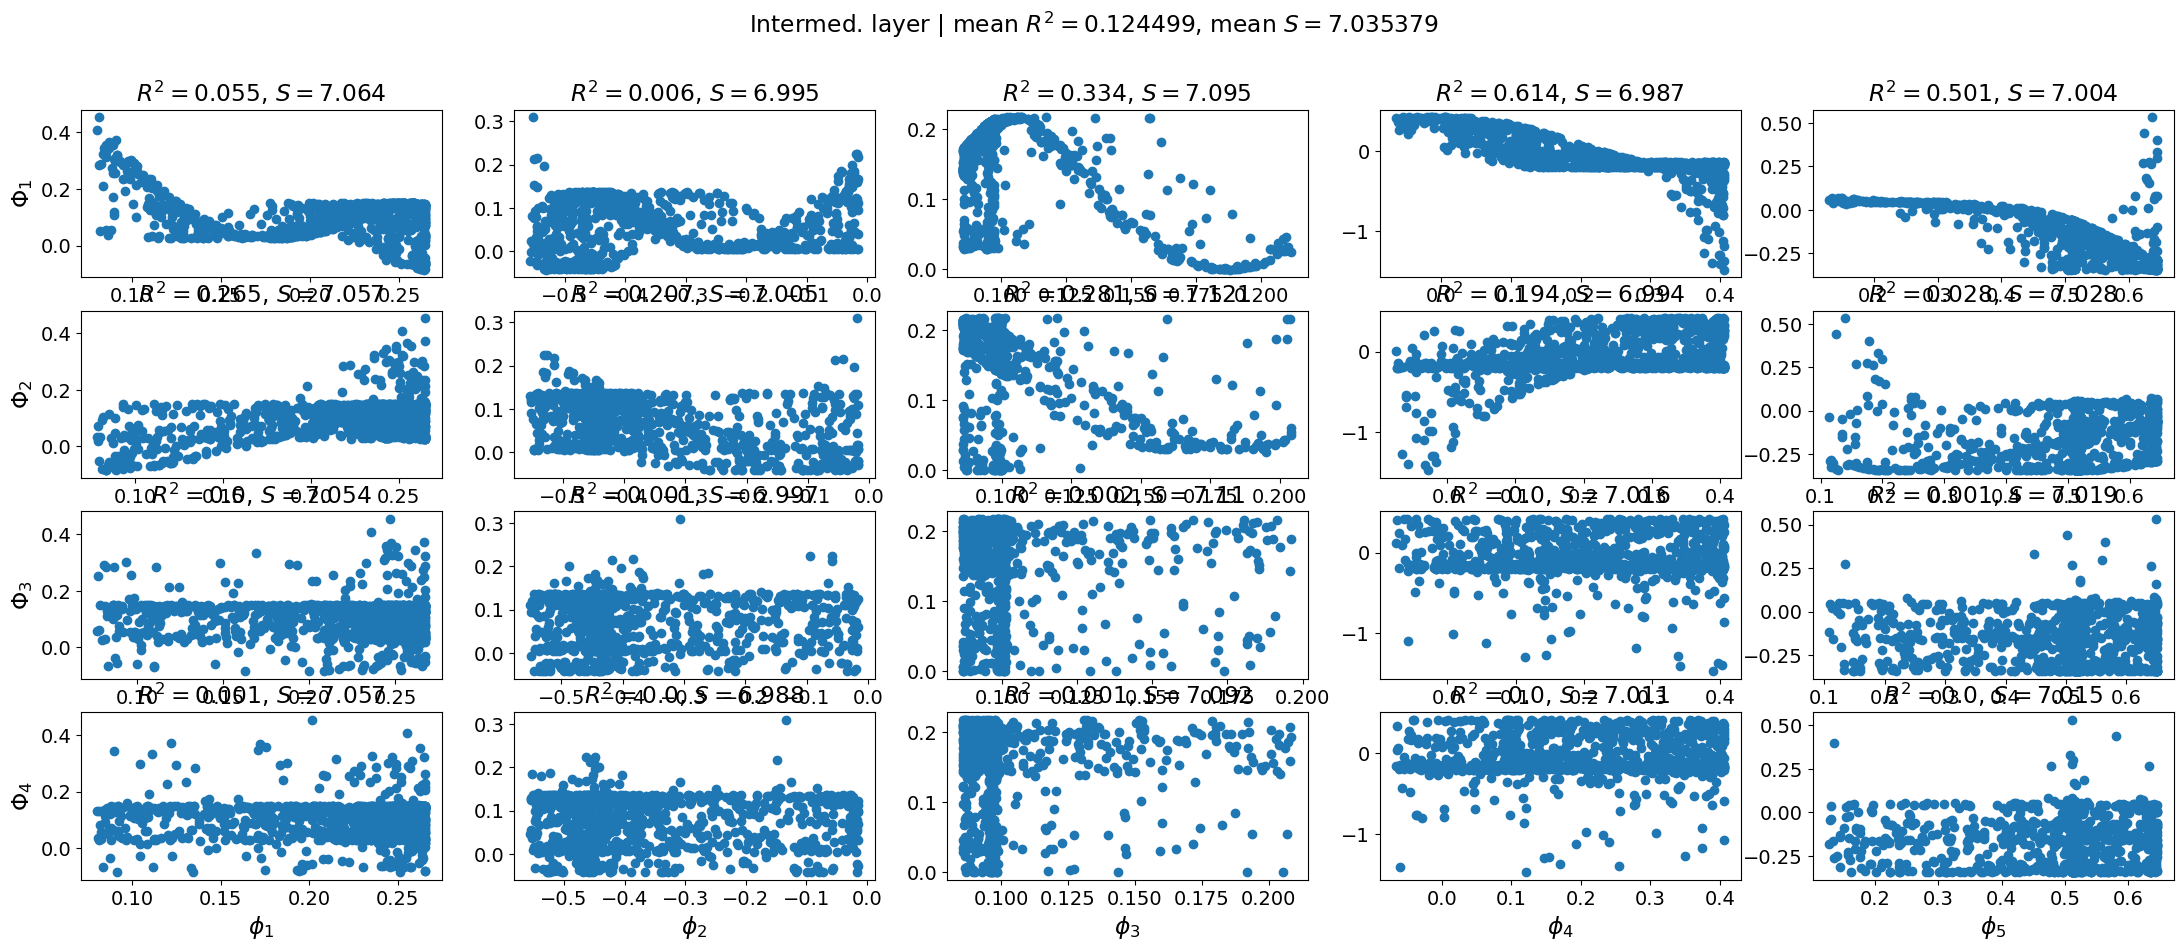

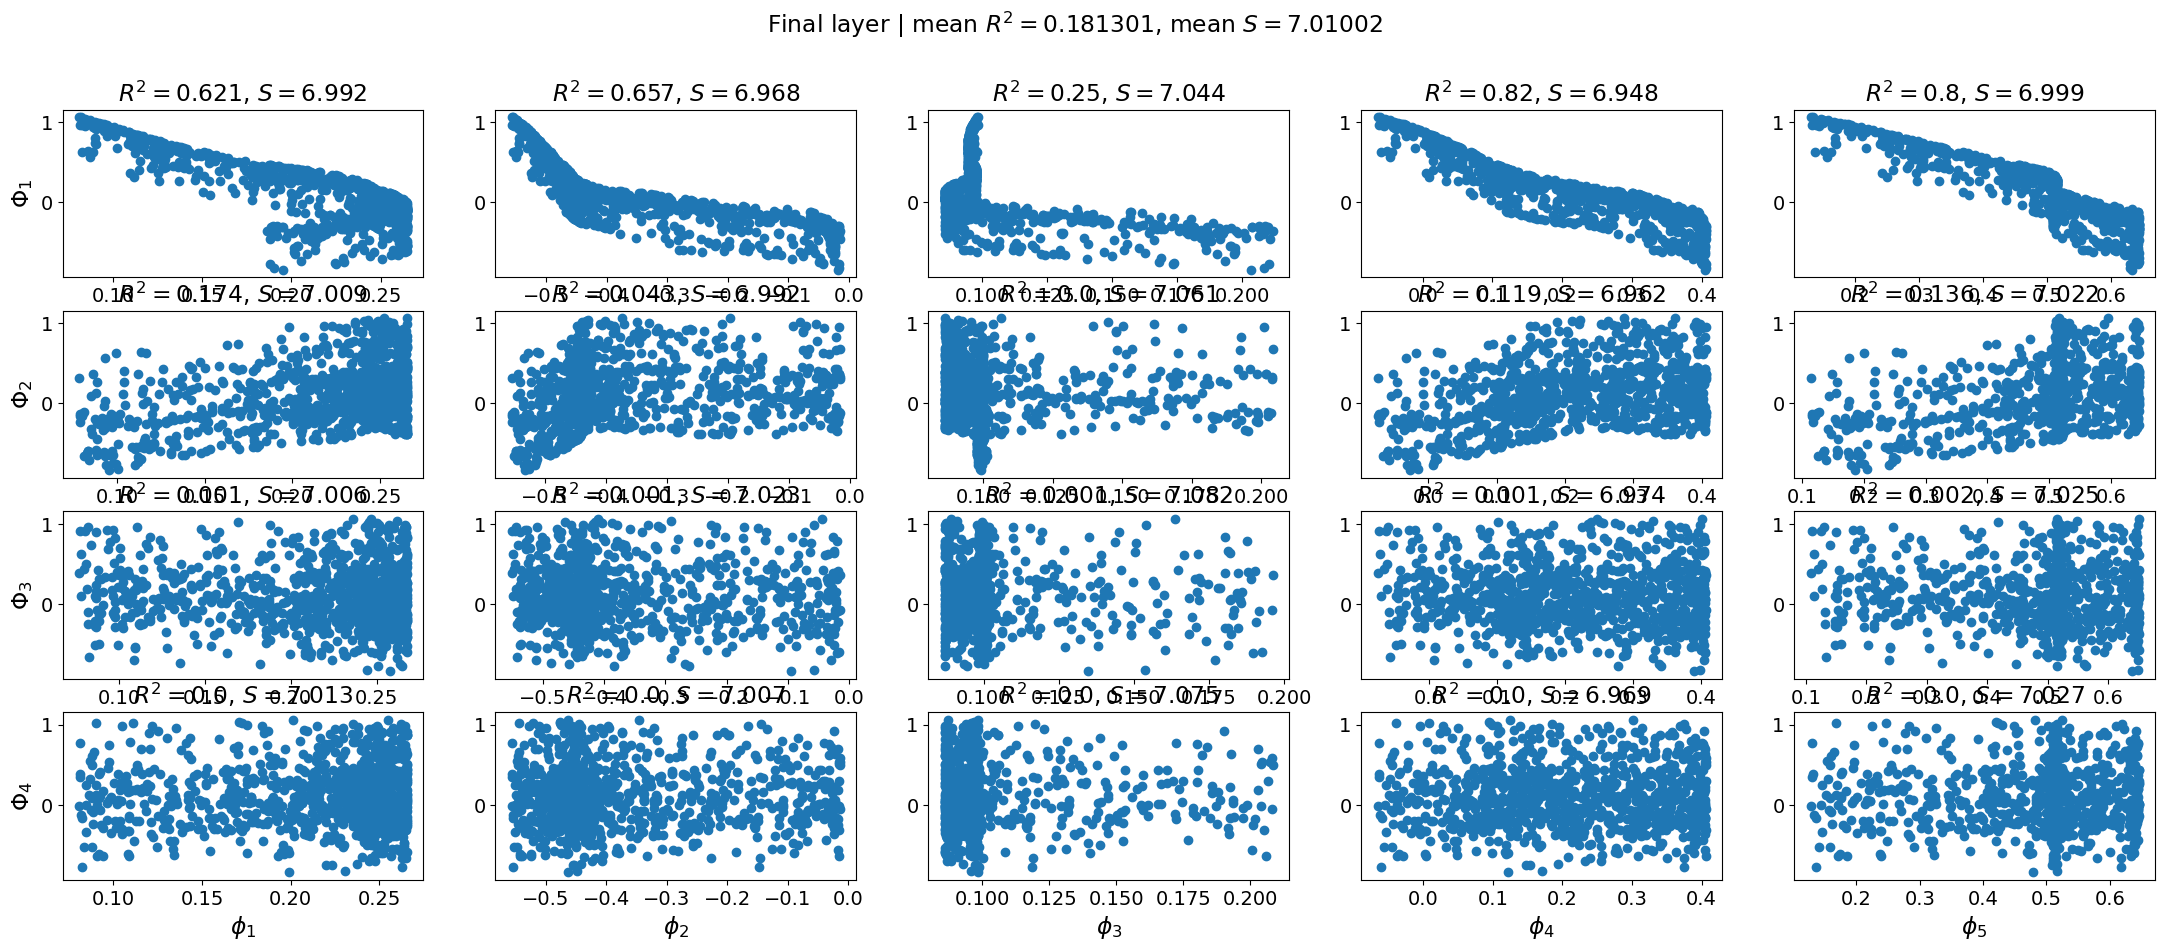

{'mean_r2': 0.18130105290482063, 'mean_matrix_entropy': 7.010019779205322}

In [16]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_3$ with __Entropy regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 3.43e-02 | test_loss: 3.64e-02 | reg: 6.82e+00 | : 100%|█| 150/150 [01:49<00:00,  1.37


saving model version 0.1


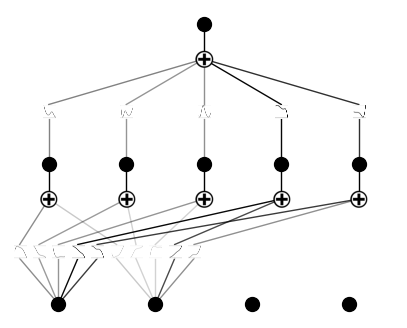

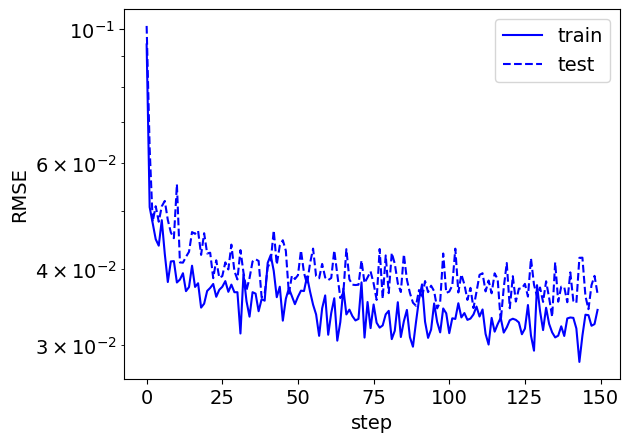

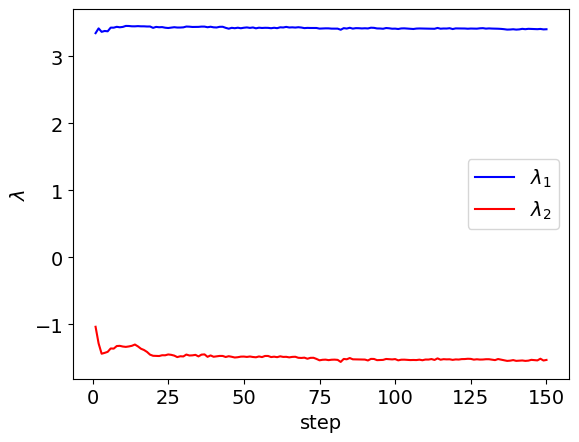

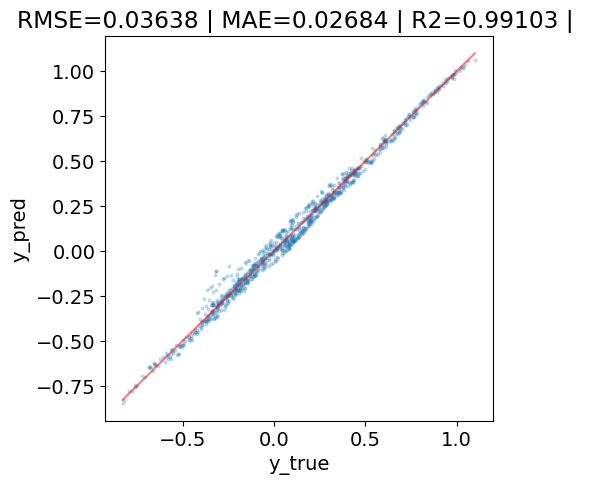

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.4065e+00, -1.5322e+00,  3.7991e-04,  7.3001e-05],
       requires_grad=True)


In [17]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:28, 23.17it/s]                         


module of Input importance:


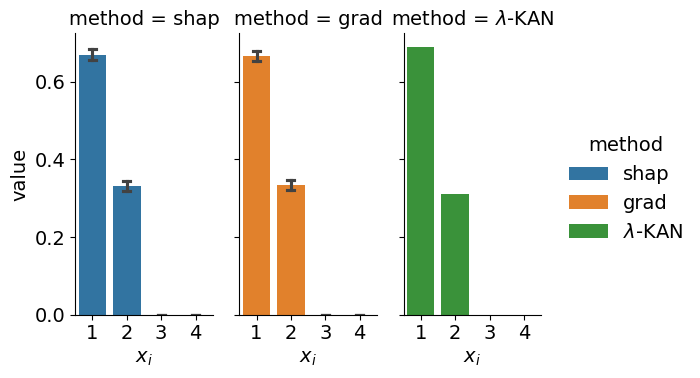

Input importance:


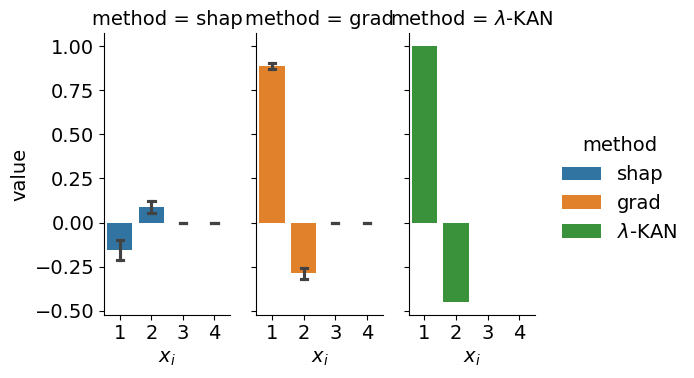

In [18]:
importance_analyse_lmdKAN(model, dataset)

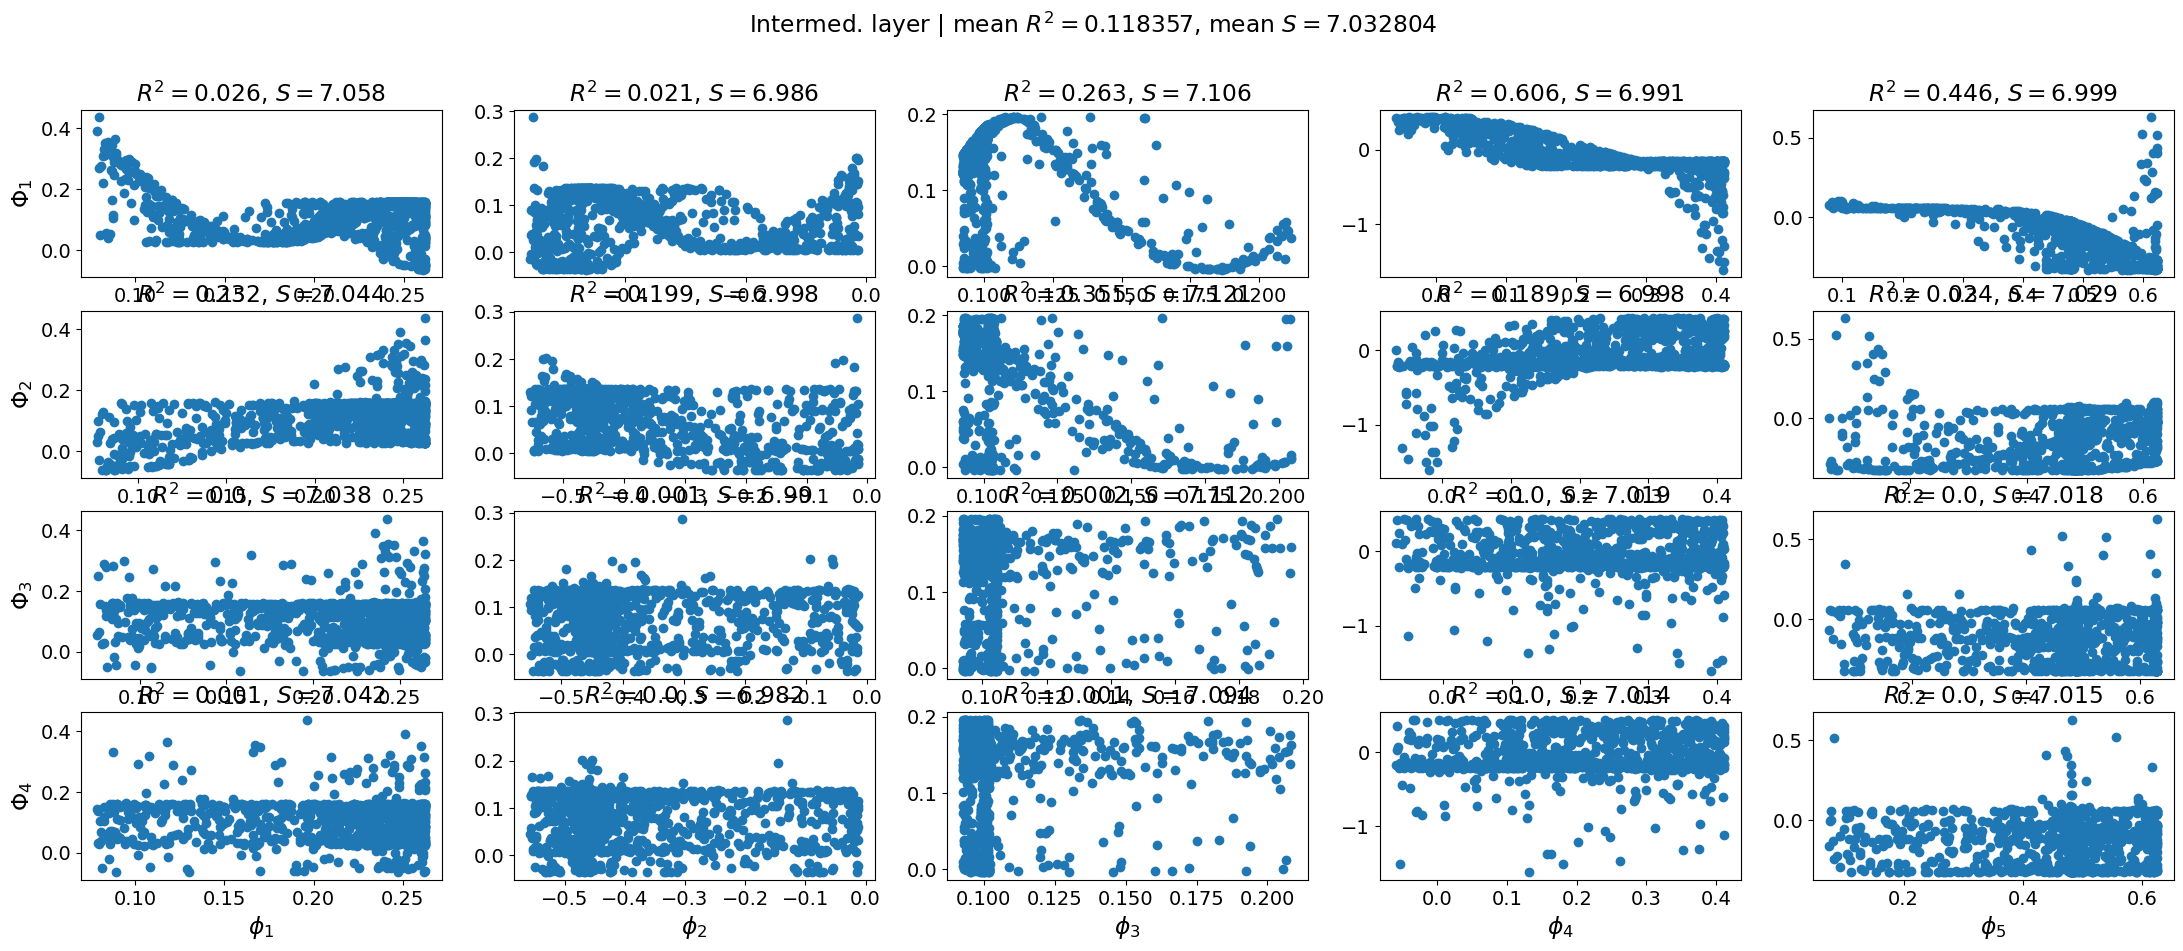

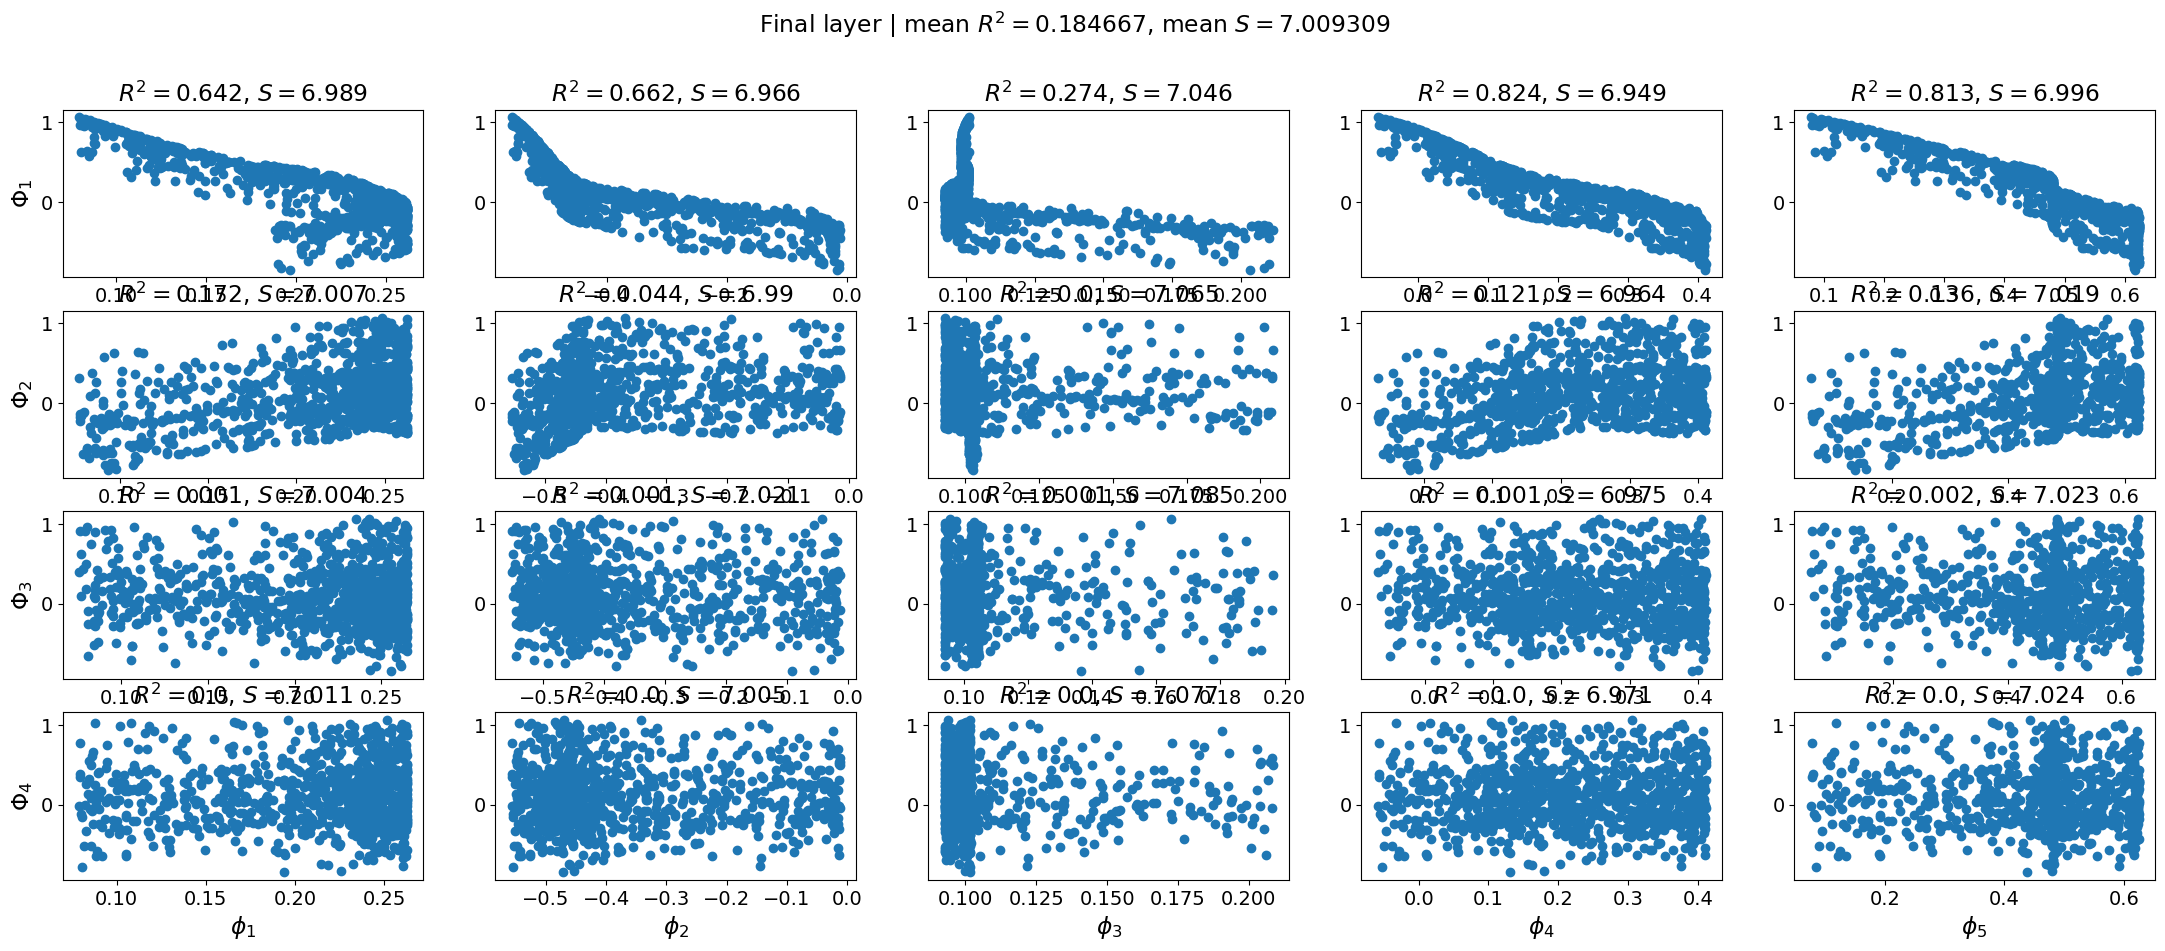

{'mean_r2': 0.1846670243353202, 'mean_matrix_entropy': 7.0093092918396}

In [19]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_3$ with __R2 regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 3.65e-02 | test_loss: 3.95e-02 | reg: 6.95e+00 | : 100%|█| 150/150 [02:10<00:00,  1.15


saving model version 0.1


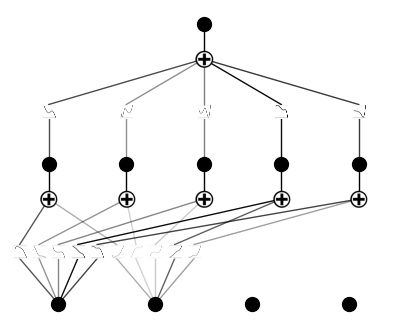

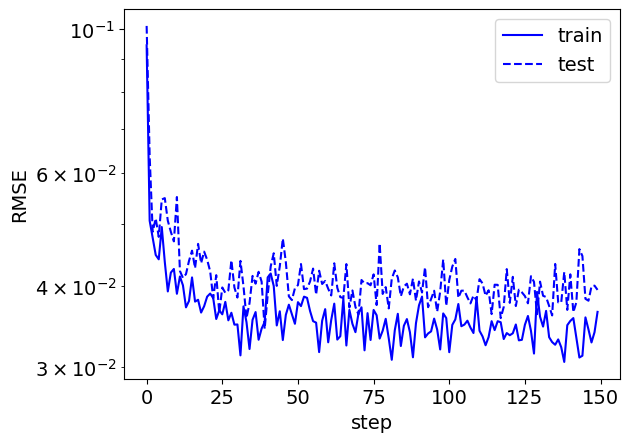

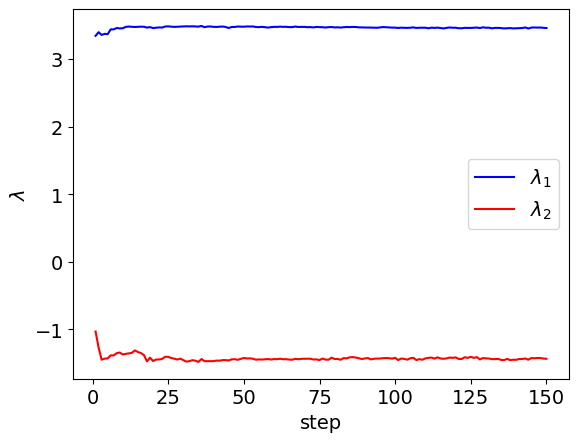

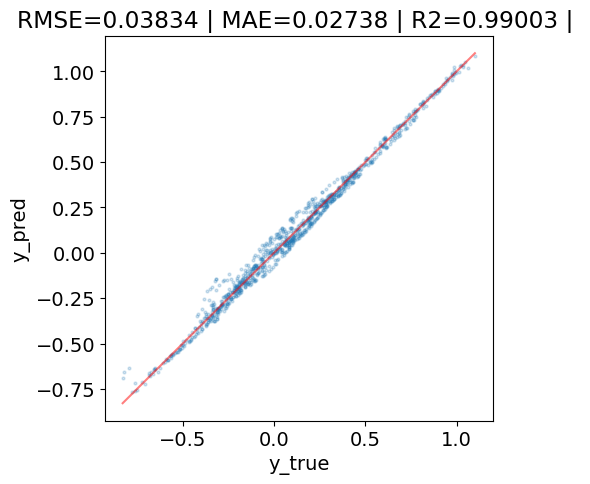

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.4562e+00, -1.4325e+00, -7.6447e-04, -1.9679e-03],
       requires_grad=True)


In [20]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:31, 21.73it/s]                         


module of Input importance:


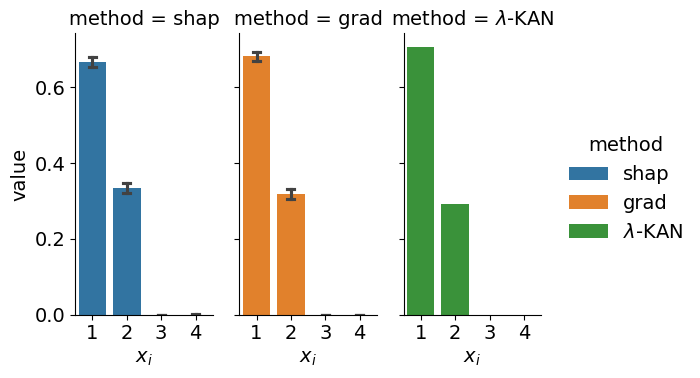

Input importance:


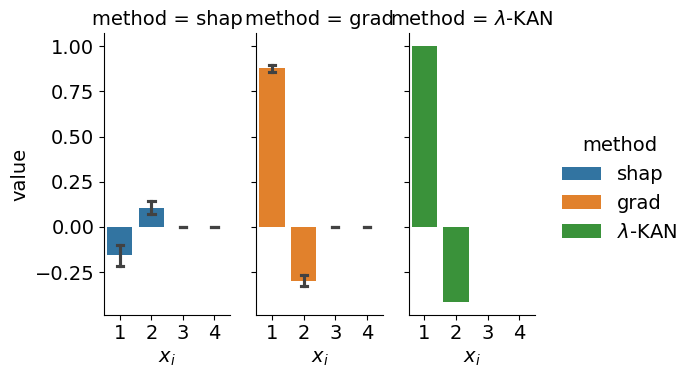

In [21]:
importance_analyse_lmdKAN(model, dataset)

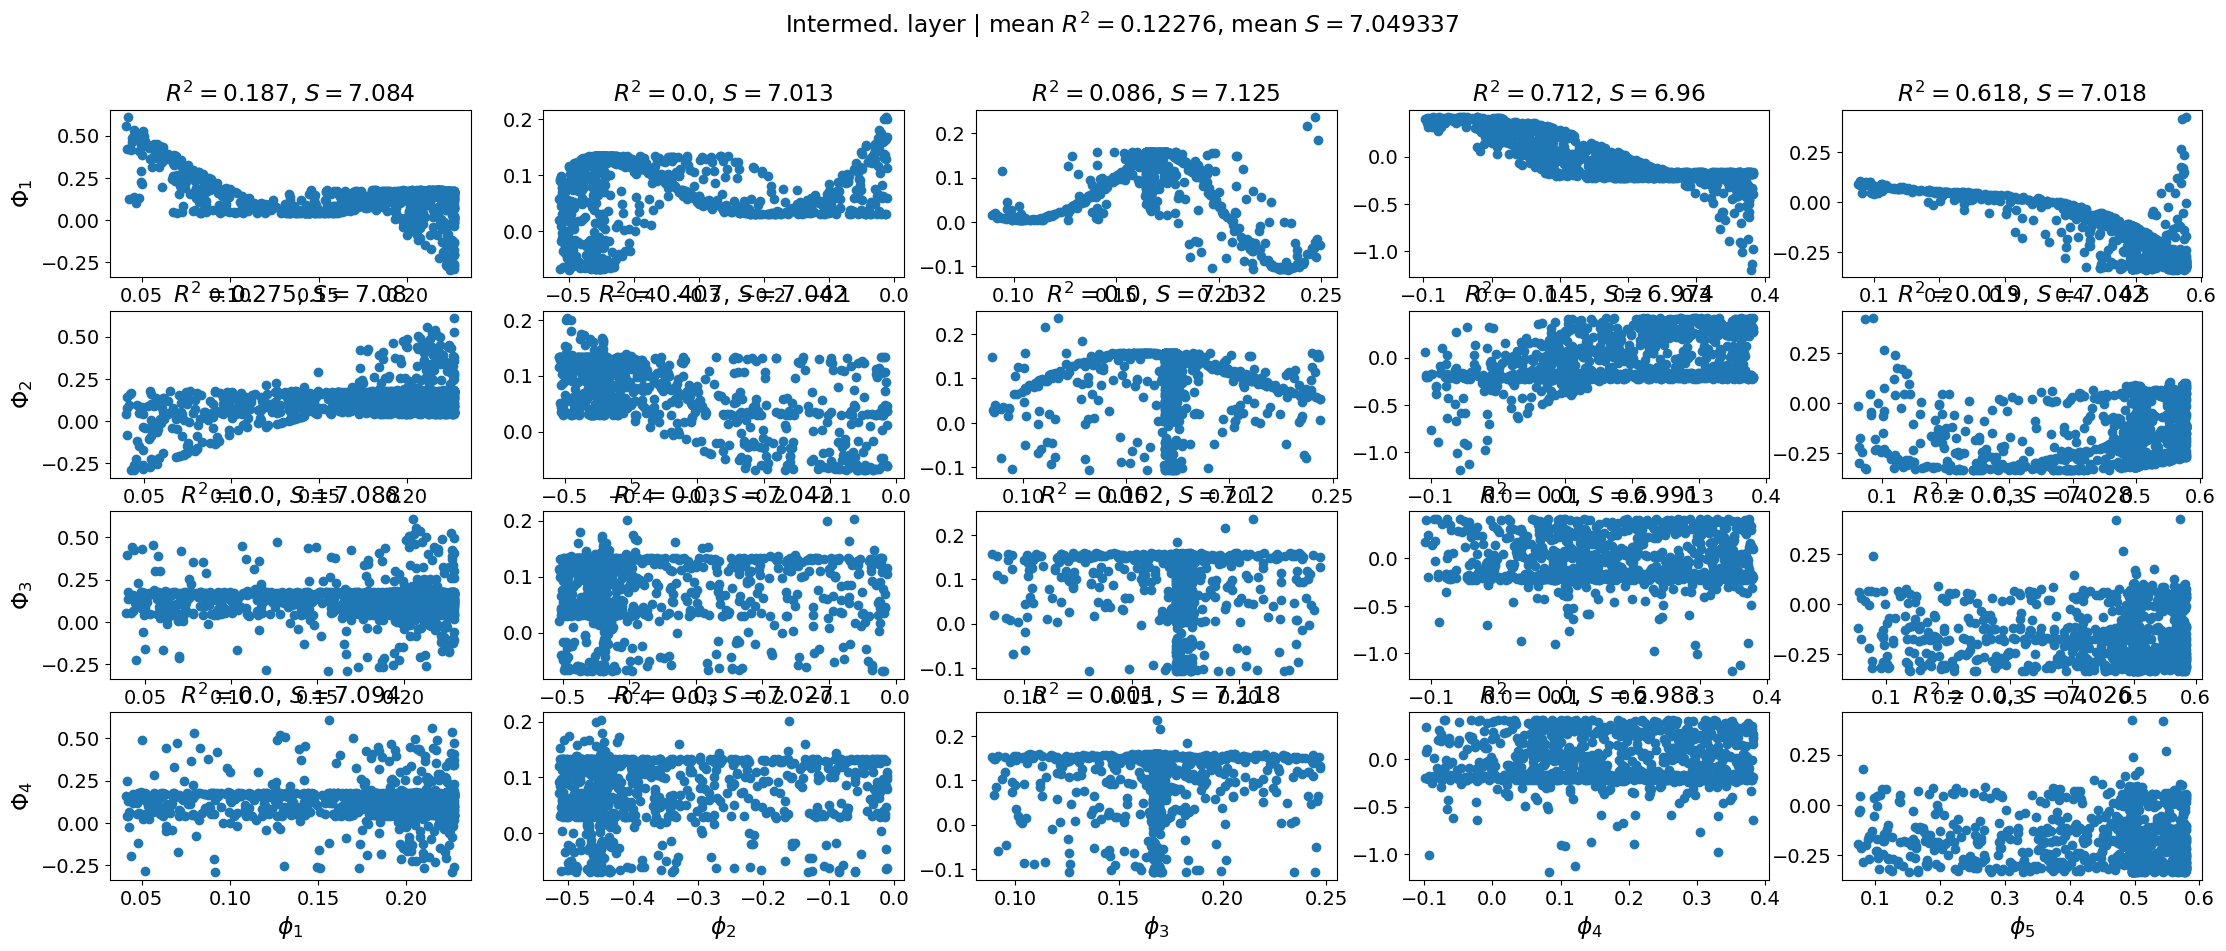

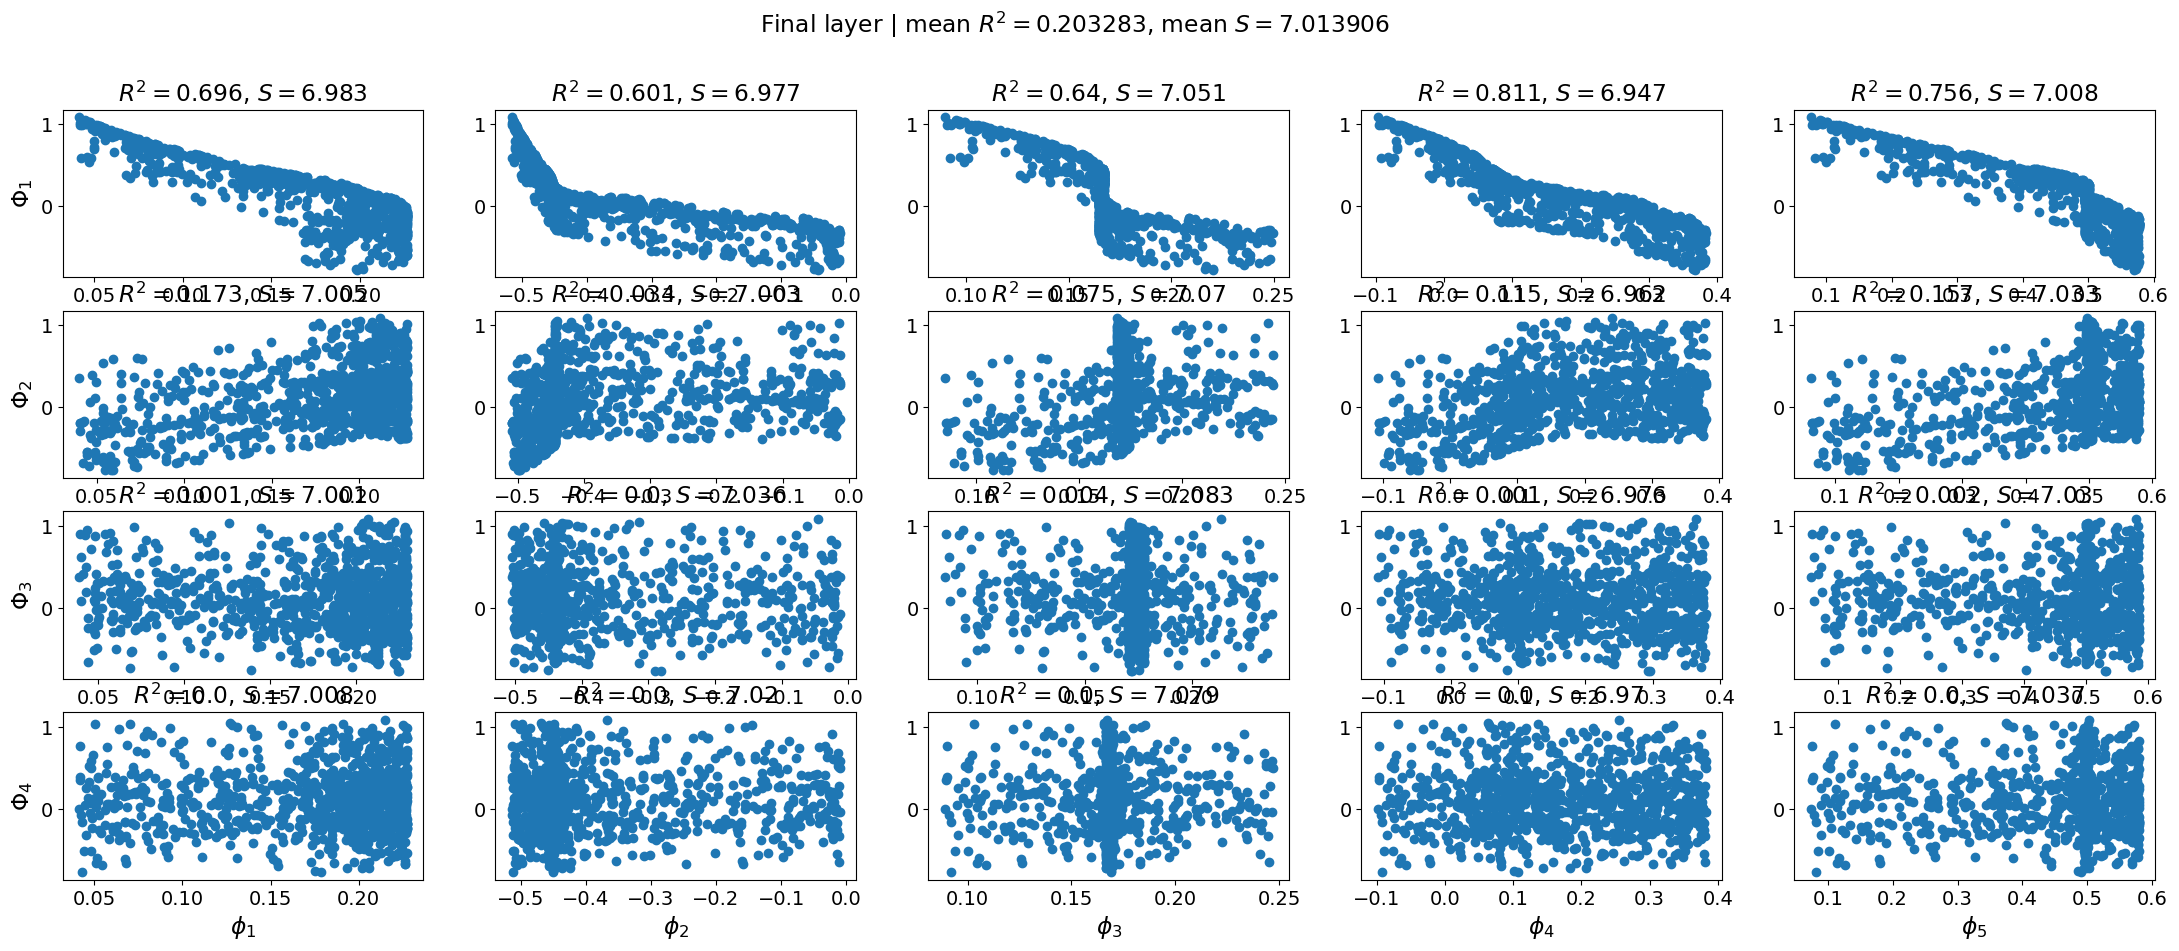

{'mean_r2': 0.20328294951462808, 'mean_matrix_entropy': 7.013906002044678}

In [22]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_3$ with __Entropy regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 3.61e-02 | test_loss: 3.82e-02 | reg: 6.87e+00 | : 100%|█| 150/150 [03:14<00:00,  1.30


saving model version 0.1


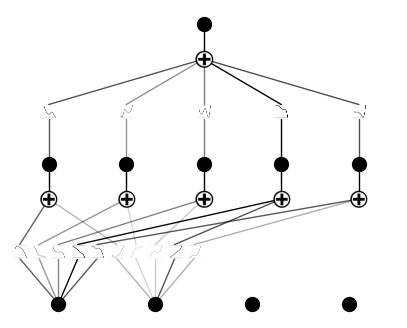

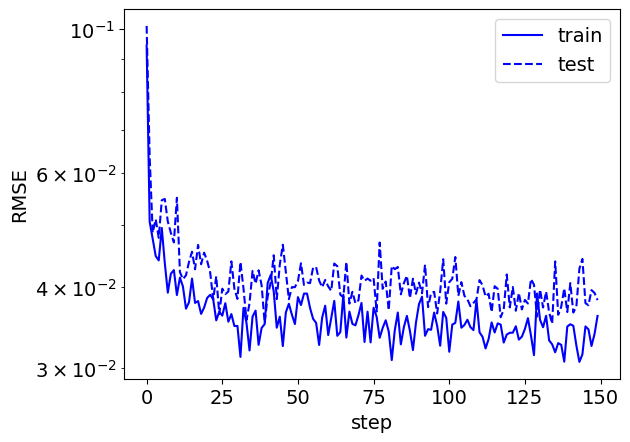

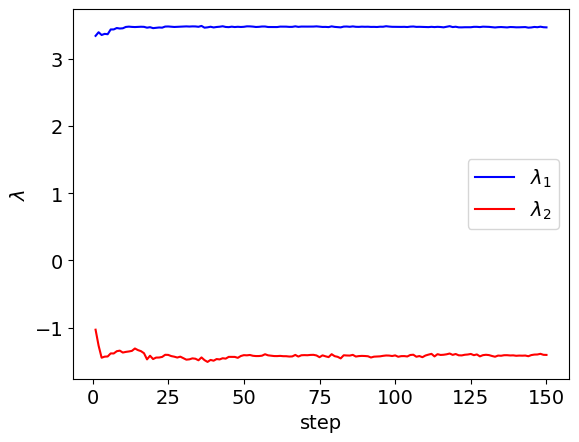

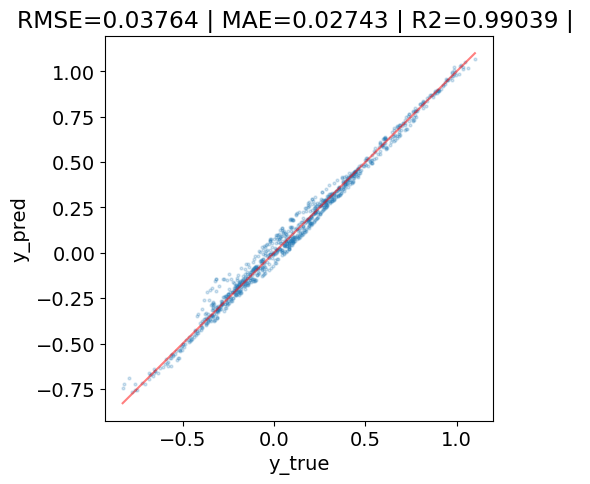

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.4668e+00, -1.4051e+00, -2.0118e-04,  2.2921e-04],
       requires_grad=True)


In [23]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:45, 16.40it/s]                         


module of Input importance:


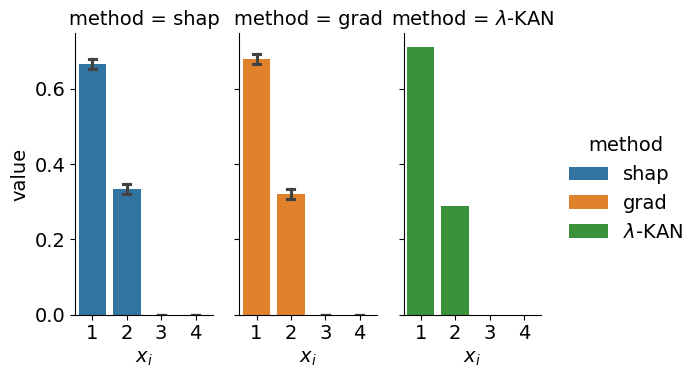

Input importance:


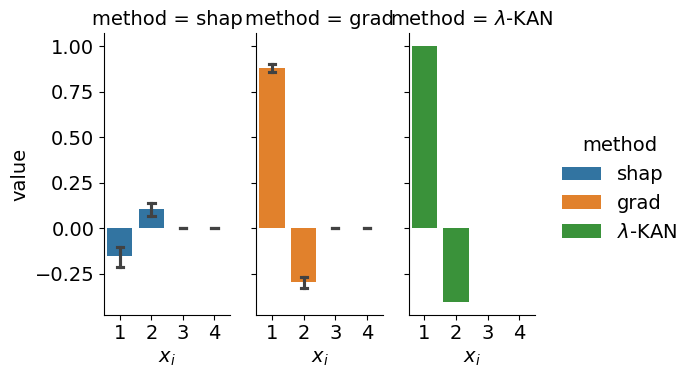

In [24]:
importance_analyse_lmdKAN(model, dataset)

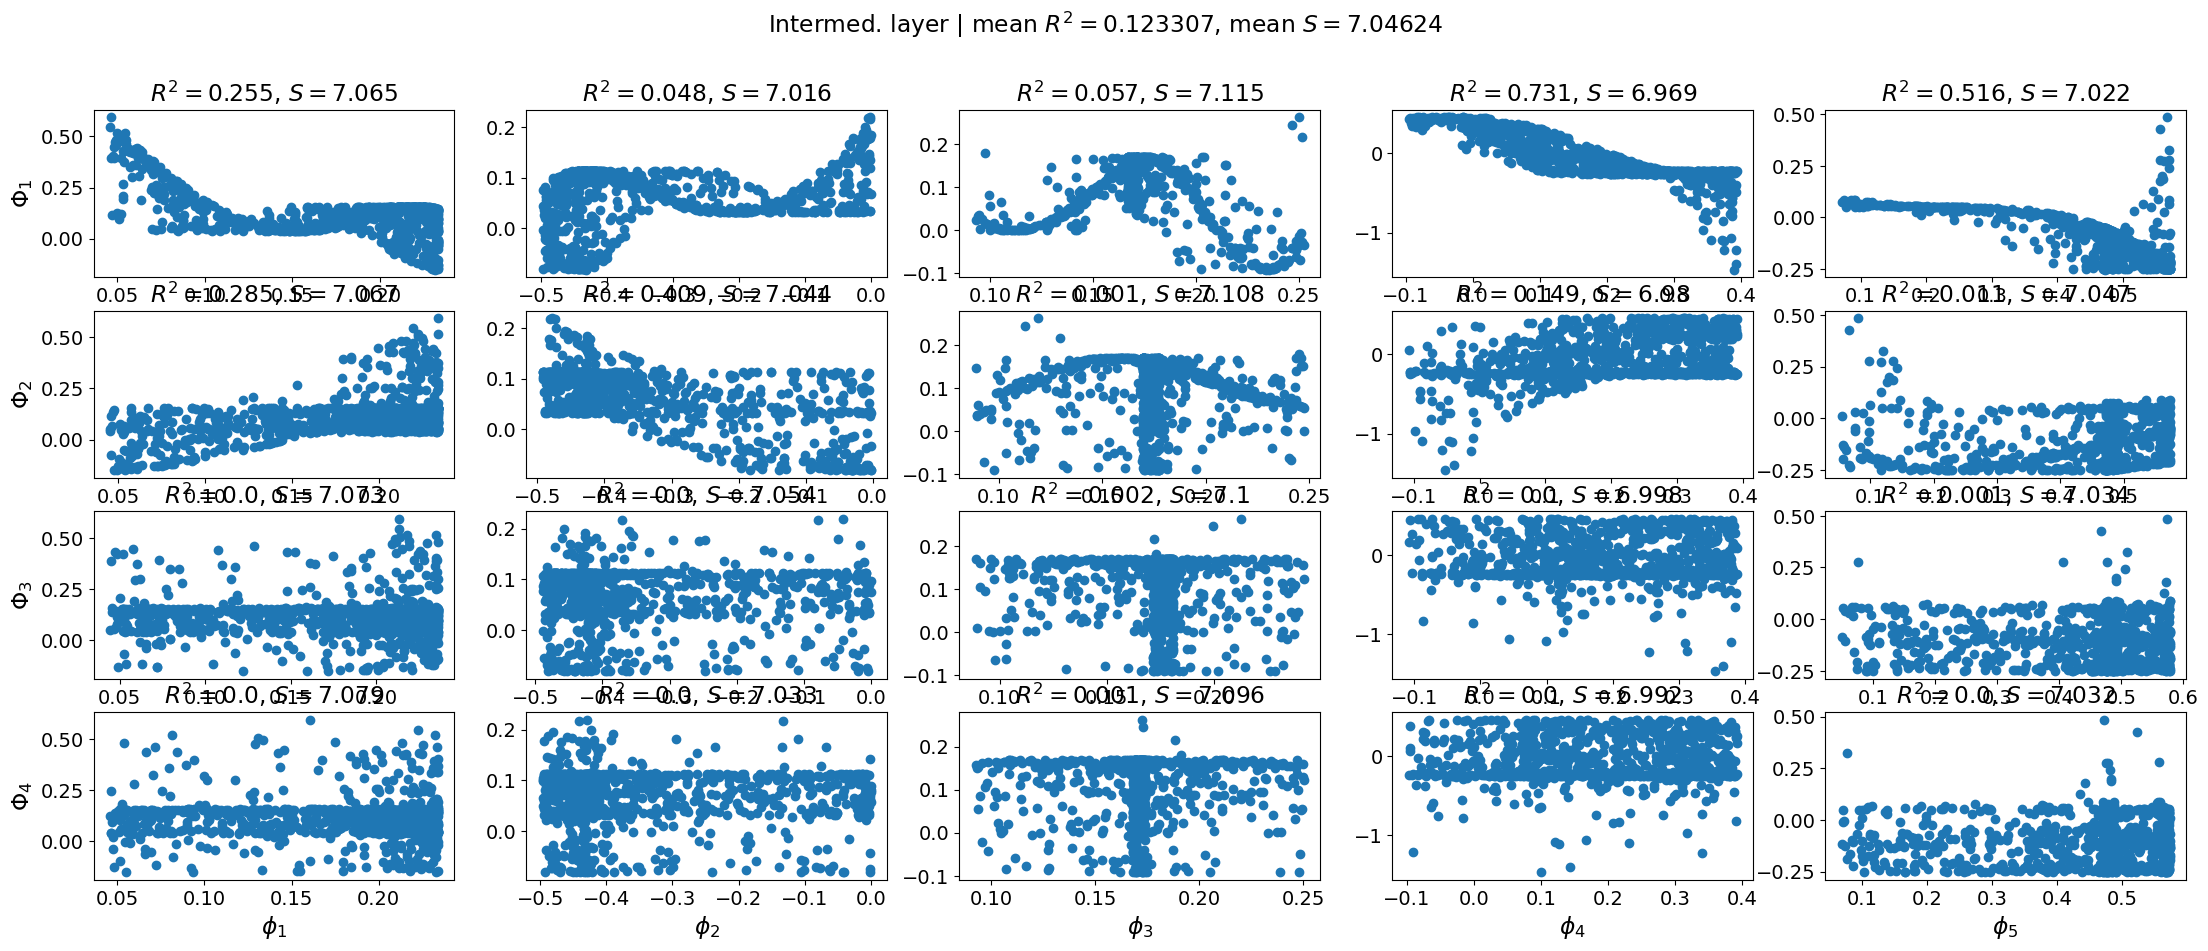

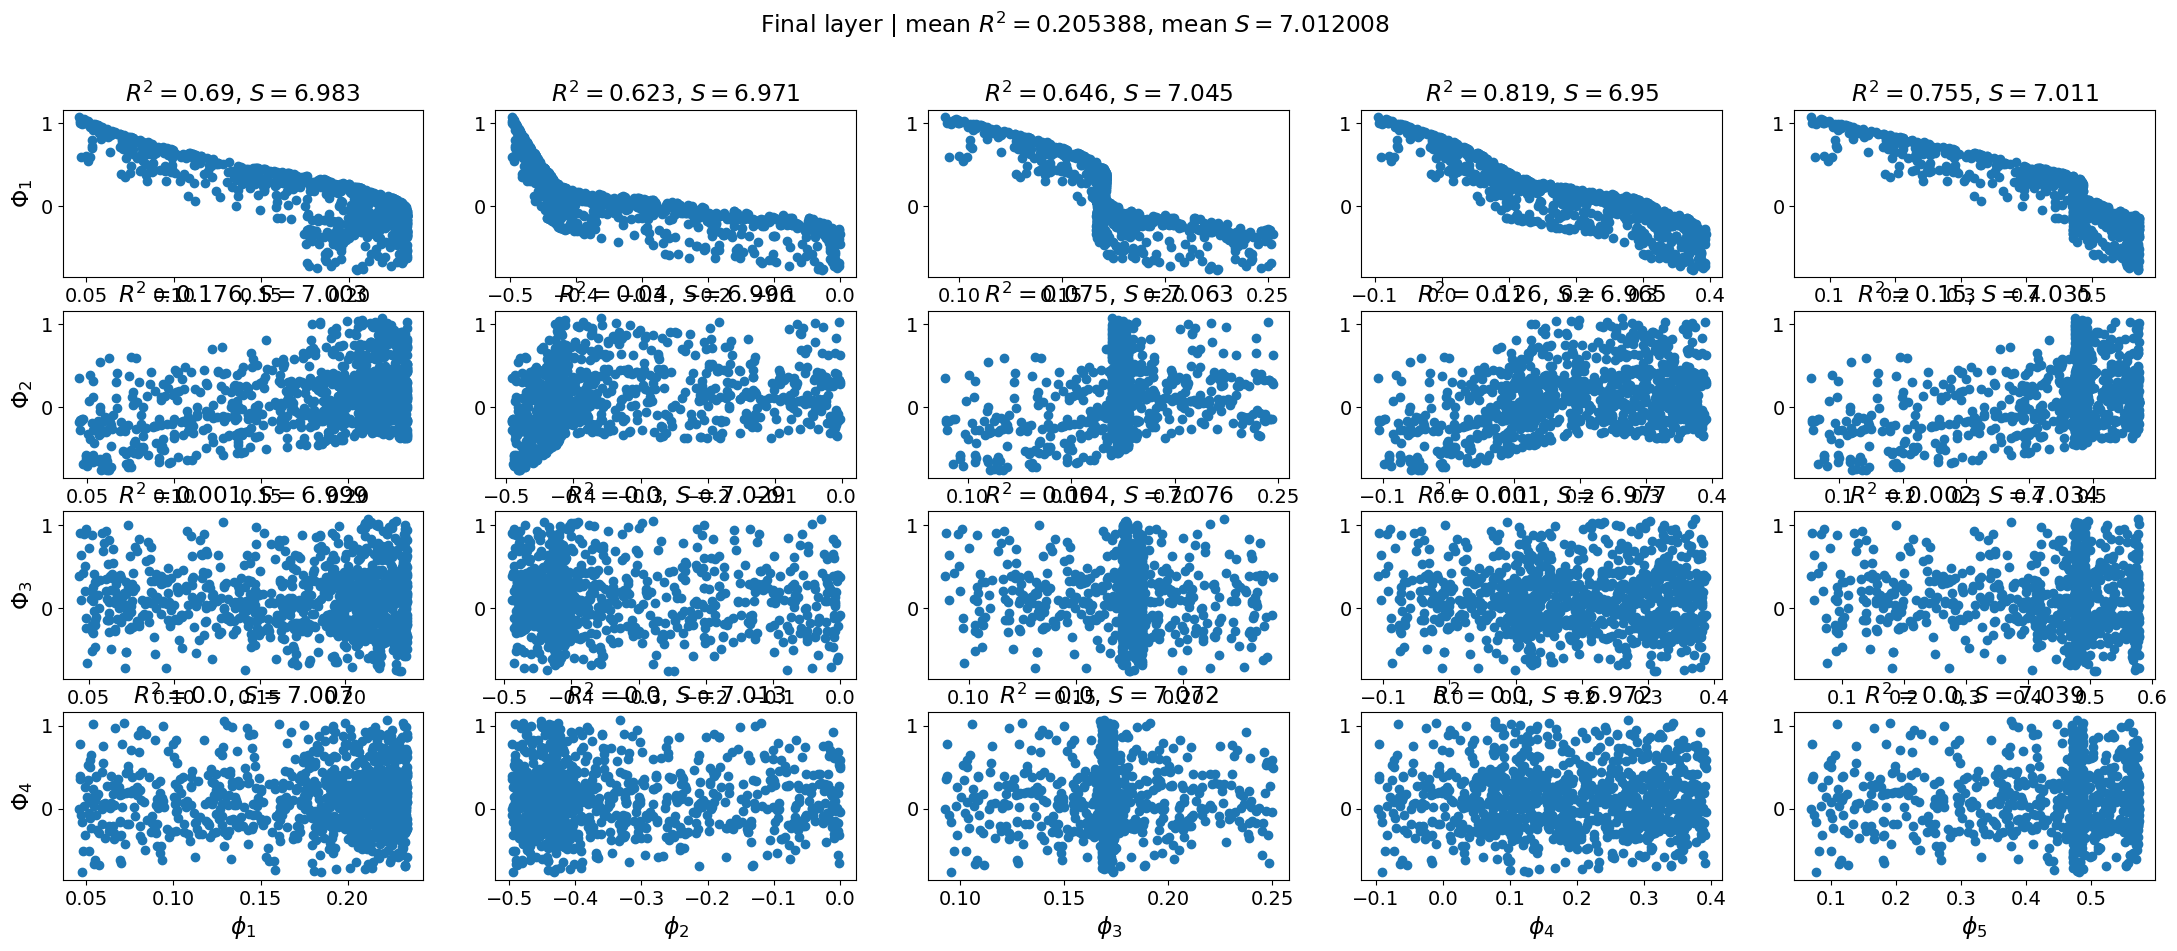

{'mean_r2': 0.20538848465458273, 'mean_matrix_entropy': 7.012007713317871}

In [25]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')